In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors

import seaborn as sns
from sklearn.manifold import TSNE
import numpy.random as random
import math
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn import datasets


In [ ]:
# def measure_option1 (X, T_value, p, vector_representants): # (3) iloczyn skalarny
#     measurements = []

#     for i in range(p):
#         measurements.append(np.dot(vector_representants[i], X[T_value % len(X)]))

#     max_index = (np.where (measurements == np.amax(measurements)))

#     return max_index[0][0]

# def measure_option2 (X, T_value, p, vector_representants): # (4) odległość euklidesowa
#     measurements = []

#     for i in range(p):
#         measurements.append(np.linalg.norm(vector_representants[i] - X[T_value % len(X)]))

#     min_index = (np.where (measurements == np.amin (measurements)))

#     return min_index[0][0]

# def measure_option3 (X, T_value, p, vector_representants): # (5)  suma różnic bezwzględnych miedzy współrzędnymi
#     measurements = []

#     for i in range(p):
#         sum_pom = 0
#         for j in range(len(vector_representants[0])):
#             sum_pom += abs (vector_representants[i][j] - X[T_value % len(X)][j]) 
#         measurements.append(math.sqrt(sum_pom))
    
#     min_index = (np.where(measurements == np.amin(measurements)))

#     return min_index[0][0]
# measure_options = [measure_option1, measure_option2, measure_option3]


In [2]:
def calc_scalar_product(X, T_value, num_repres, repres): 
    measurements = [np.dot(rep, X[T_value % len(X)]) for rep in repres[:num_repres]]
    max_index = np.argmax(measurements)
    return max_index

def calc_euclidean_distance(X, T_value, num_repres, repres): 
    measurements = [np.linalg.norm(rep - X[T_value % len(X)]) for rep in repres[:num_repres]]
    min_index = np.argmin(measurements)
    return min_index

def calc_absolute_difference(X, T_value, num_repres, repres): 
    measurements = []
    
    for rep in repr[:num_repres]:
        absolute_diff = np.abs(rep - X[T_value % len(X)])
        measurements.append(np.sqrt(np.sum(absolute_diff)))
    
    min_index = np.argmin(measurements)
    return min_index

measure_methods = [calc_scalar_product, calc_euclidean_distance, calc_absolute_difference]


In [ ]:
# def Kohonen (X,T, alfa, p, learning_rate, measure_option, C1,C2,std): 
#     """ 
#     X - dane
#     T - liczba iteracji
#     alfa - wspolczynnik uczenia
#     p - liczba reprezentantów
#     learning_rate - 1 - malejacy, 2 - wykladniczy, 3 - hiperboliczne zmniejszanie
#     measure_option - 1 - (3), 2 - (4), 3 - (5)
#     C1 - parametr dla learning_rate = 2
#     C2 - parametr dla learning_rate = 3
#     std - czy normalizowac dane
#     """
#     if std:
#         X_std = []
#         sum_x = 0

#         for i in range(len(X)):
#             sum_x += X[i]
        
#         sr= sum_x/len(X)

#         for i in range(len(X)):
#             X_std.append((sr-X[i])/np.linalg.norm(sr-X[i]))

#         X_std = np.array(X_std)
#         X = X_std
    
#     vector=[]
#     rand_gen = np.random.RandomState(0)

#     for i in range(p):
#         for j in range(len(X)):
#             vector_temp = rand_gen.normal(loc=0.0, scale=0.01, size=len(X[0]))
#             vector.append(vector_temp/np.linalg.norm(vector_temp))
        
#         vector_representants = np.array(vector)

#     Tabela_m = [0] *len(X)
#     alfa_koh=alfa
#     for t in range(T):
#         if measure_option==1:
#             mod = measure_option1(X, t, p, vector_representants)
#             Tabela_m[t%len(X)]=mod
#         elif measure_option==2:
#             mod = measure_option2(X, t, p, vector_representants)
#             Tabela_m[t%len(X)]=mod
#         elif measure_option==3:
#             mod = measure_option3(X, t, p, vector_representants)
#             Tabela_m[t%len(X)]=mod
        
#         vector_representants[mod] = vector_representants[mod] + alfa_koh * (X[t%len(X)] - vector_representants[mod])
#         vector_representants[mod] = vector_representants[mod]/np.linalg.norm(vector_representants[mod])

#         if learning_rate == 1:
#             alfa_koh = alfa*(T-t)/T
#         elif learning_rate == 2:
#             alfa_koh = alfa * math.exp(-C1 * t)
#         elif learning_rate == 3:
#             alfa_koh = C1/(C2+t)
    
#     return vector_representants, Tabela_m, X


In [3]:
def norm_data(X):
    data_mean = np.mean(X, axis=0)
    X_norm = (X - data_mean) / np.linalg.norm(X - data_mean, axis=1, keepdims=True)
    return X_norm

def init_vecs(X, num_vecs):
    rand_gen = np.random.RandomState(0)
    vecs = rand_gen.normal(loc=0.0, scale=0.01, size=(num_vecs, len(X[0])))
    vecs /= np.linalg.norm(vecs, axis=1, keepdims=True)
    return vecs

def update_lr(lr_option, init_lr, C1, C2, curr_iter, total_iter):
    if lr_option == 1:
        return init_lr * (total_iter - curr_iter) / total_iter
    elif lr_option == 2:
        return init_lr * math.exp(-C1 * curr_iter)
    elif lr_option == 3:
        return C1 / (C2 + curr_iter)
    else:
        raise ValueError("Invalid lr_option")

def Kohonen(X, T, init_lr, num_vecs, lr_option, measure_opt, C1, C2, norm): 
    """
    X - dane
    T - liczba iteracji
    init_lr - wspolczynnik uczenia
    num_vecs - liczba reprezentantów
    lr_option - 1 - malejacy, 2 - wykladniczy, 3 - hiperboliczne zmniejszanie
    measure_opt - 1 - skalar, 2 - euklidesowa, 3 - manhattanska
    C1 - parametr dla lr_option = 2
    C2 - parametr dla lr_option = 3
    norm - czy normalizowac dane
    """
    if norm:
        X = norm_data(X)

    vecs = init_vecs(X, num_vecs)

    measure_tab = np.zeros(len(X))

    for i in range(T):
        sel_index = measure_opt(X, i, num_vecs, vecs)
        measure_tab[i % len(X)] = sel_index

        vecs[sel_index] += init_lr * (X[i % len(X)] - vecs[sel_index])
        vecs[sel_index] /= np.linalg.norm(vecs[sel_index])

        init_lr = update_lr(lr_option, init_lr, C1, C2, i, T)
    
    return vecs, measure_tab, X


In [4]:
def bestNumberOfClass(X, start_class, number):
    """
    X - dane
    start_class - poczatek przedzialu
    number - liczba klas
    """
    P = []

    for p in range(2,5):
        vector_representants, Tabela_m, X_koh = Kohonen(X, 1500, 0.1, p, 1, 1, 1, 1, True)
        result = davies_bouldin_score(X, Tabela_m)
        P.append(result)
    print(np.argmin(result)+start_class)


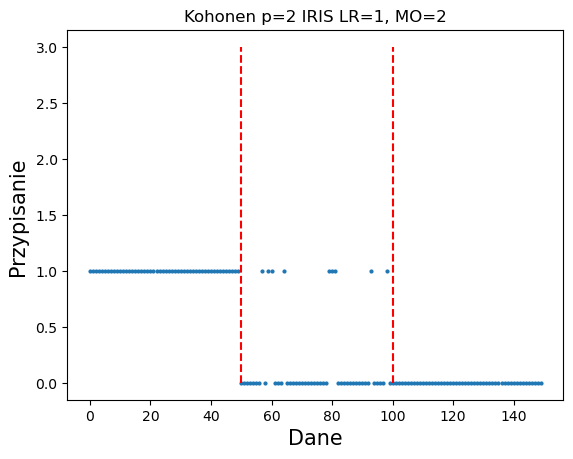

c:\Users\aleks\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\aleks\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\aleks\AppData\Local\Temp\ipykernel_5960\4102833888.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=np.array(sns.color_palette("Paired"))[predictions_np.astype(np.int)])


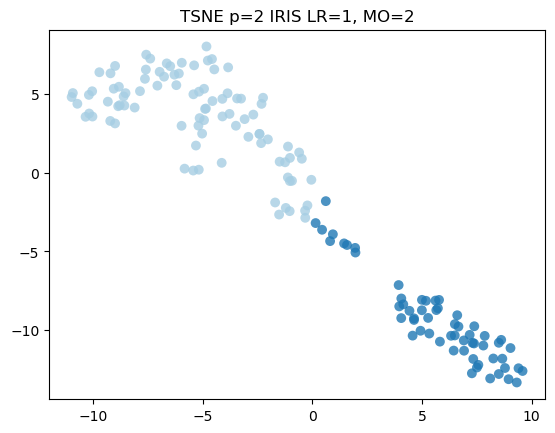

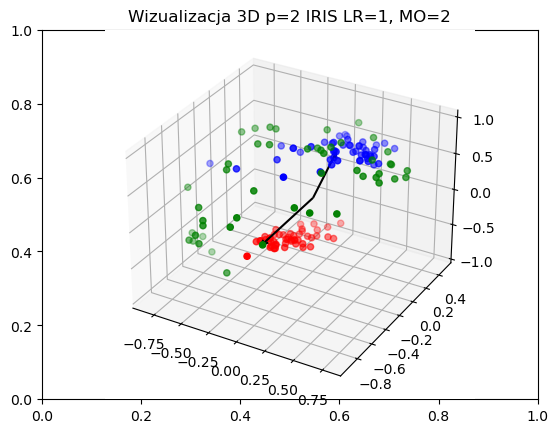

In [7]:
# Definicja parametrów
num_iterations = 10000
learning_rate_initial = 0.1
num_representatives = 2
learning_rate_type = 1 
measure_method = measure_methods[0]
param_C1 = 0.3
param_C2 = 0.4
normalize_data = True
plot_title = 'p=2 IRIS LR=1, MO=2'

# Wczytanie danych
dataset = datasets.load_iris()
data = dataset.data

# Obliczenie Kohonena
kohonen_result, predictions, transformed_data = Kohonen(
    data, 
    num_iterations, 
    learning_rate_initial, 
    num_representatives, 
    learning_rate_type, 
    measure_method, 
    param_C1, 
    param_C2, 
    normalize_data
)

# Wykresy
predictions_np = np.array(predictions)
plt.figure()
plt.plot(predictions_np, 'o',  markersize=2)
plt.vlines([50,100],0,3, colors='r', linestyles='dashed')
plt.title('Kohonen {}'.format(plot_title))
plt.xlabel('Dane', fontsize=15)
plt.ylabel('Przypisanie ', fontsize=15)
plt.show()

# Wykresy t-SNE
tsne_result = TSNE(random_state=1).fit_transform(transformed_data)
plt.figure()
plt.scatter(tsne_result[:,0], tsne_result[:,1], lw=0, s=50, alpha=0.8, edgecolors='black',
             c=np.array(sns.color_palette("Paired"))[predictions_np.astype(np.int)])
plt.title('TSNE {}'.format(plot_title))
plt.show()

# Wykresy 3D
center = [0,0,0]
fig = plt.figure()
plt.title('Wizualizacja 3D {}'.format(plot_title))
ax = fig.add_subplot(111,projection='3d')
u1, v1, w1 = zip(center, center)
u2, v2, w2 = zip(kohonen_result[0, 0:3], kohonen_result[1, 0:3])
ax.quiver(u1, v1, w1, u2, v2, w2, arrow_length_ratio=0.1, colors='black')
ax.scatter(transformed_data[0:49,0], transformed_data[0:49,1], transformed_data[0:49,2], c='r')
ax.scatter(transformed_data[50:99,0], transformed_data[50:99,1], transformed_data[50:99,2], c='g')
ax.scatter(transformed_data[99:149,0], transformed_data[99:149,1], transformed_data[99:149,2], c='b')
plt.show()


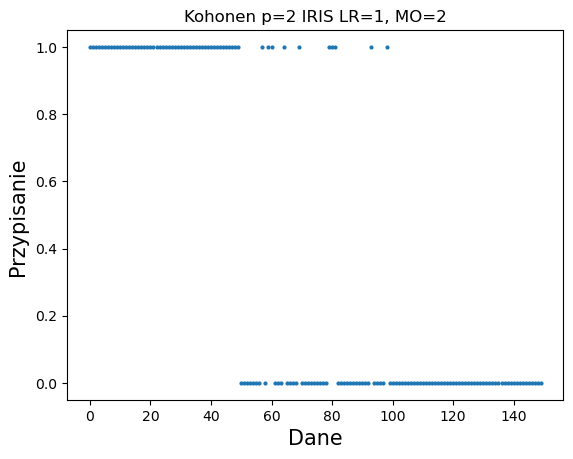

c:\Users\aleks\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\aleks\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\aleks\AppData\Local\Temp\ipykernel_5960\2664960916.py:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(tsne[:,0],tsne[:,1],lw=0,s=50, alpha=0.8, edgecolors='black'

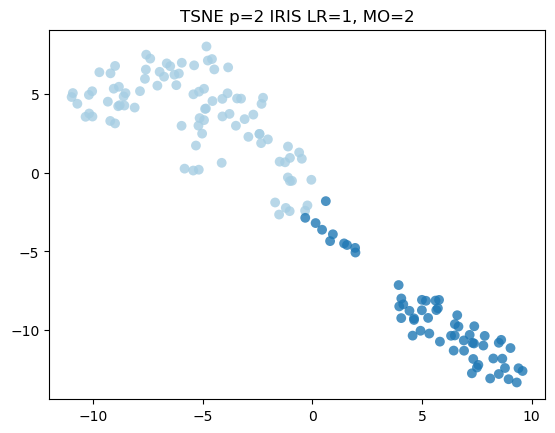

<Figure size 640x480 with 0 Axes>

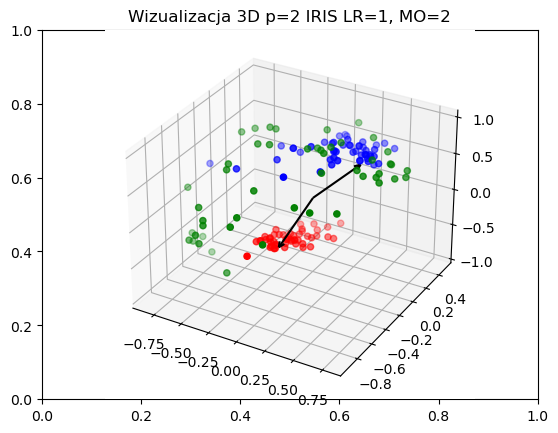

In [9]:
dt = datasets.load_iris()
X = dt.data
y = dt.target
title = 'p=2 IRIS LR=1, MO=2'
# bestNumberOfClass(X, 2, 5)
koh, predicts, X_koh = Kohonen(X, 10000, 0.1, 2, 3, measure_methods[1], 0.3, 0.4, True)
""" 
    X - dane
    T - liczba iteracji
    alfa0 - wspolczynnik uczenia
    p - liczba reprezentantów
    learning_rate - 1 - malejacy, 2 - wykladniczy, 3 - hiperboliczne zmniejszanie
    measure_option - 0 - skalar, 1 - euklidesowa, 2 - manhattanska
    C1 - parametr dla learning_rate = 2
    C2 - parametr dla learning_rate = 3
    std - czy normalizowac dane
"""
predicts_np = np.array(predicts)
fig = plt.figure()
plt.plot(predicts_np, 'o',  markersize=2)
#plt.vlines([50,100],0,3, colors='r', linestyles='dashed')
plt.title('Kohonen {}'.format(title))
plt.xlabel('Dane', fontsize=15)
plt.ylabel('Przypisanie ', fontsize=15)
#plt.savefig('P2_Koh_Iris_1_2.png')  
plt.show()


tsne=TSNE(random_state=1).fit_transform(X_koh)
plt.figure()
plt.scatter(tsne[:,0],tsne[:,1],lw=0,s=50, alpha=0.8, edgecolors='black', c=np.array(sns.color_palette("Paired"))[predicts_np.astype(np.int)])
plt.title('TSNE {}'.format(title))
#plt.savefig('P2_TSNE_Iris_1_2.png')  
plt.show()


plt.clf()

srodek = [0,0,0]
fig = plt.figure()
plt.title('Wizualizacja 3D {}'.format(title))
ax=fig.add_subplot(111,projection='3d')

u1,v1,w1 = zip(srodek,srodek)
u2,v2,w2 = zip(koh[0, 0:3], koh[1, 0:3])

ax.quiver(u1,v1,w1,u2,v2,w2,arrow_length_ratio=0.1,colors='black')

ax.scatter(X_koh[0:49,0],X_koh[0:49,1],X_koh[0:49,2],c='r')
ax.scatter(X_koh[50:99,0],X_koh[50:99,1],X_koh[50:99,2],c='g')
ax.scatter(X_koh[99:149,0],X_koh[99:149,1],X_koh[99:149,2],c='b')
#plt.savefig('P2_3D_Iris_1_2.png')  
plt.show()


In [ ]:
dt=pd.read_csv('APD_data.csv')
X = dt[['open','high','low','close']]
X = np.array(X)

# bestNumberOfClass(X, 2, 5)


In [10]:
dt = pd.read_csv('WineQT.csv')

X = dt.drop(columns=['quality'])
y = dt['quality']

In [11]:
koh,predicts,X_koh = Kohonen(X, 15000, 0.1, 8, 1, measure_methods[1], 0.3, 0.4, True)
""" 
    X - dane
    T - liczba iteracji
    alfa0 - wspolczynnik uczenia
    p - liczba reprezentantów
    learning_rate - 1 - malejacy, 2 - wykladniczy, 3 - hiperboliczne zmniejszanie
    measure_option - 1 - skalar, 2 - euklidesowa, 3 - manhattanska
    C1 - parametr dla learning_rate = 2
    C2 - parametr dla learning_rate = 3
    std - czy normalizowac dane
"""
predicts_np = np.array(predicts)
fig = plt.figure()
plt.plot(predicts, marker = 'o', linestyle =' ')
plt.title('kohonen', fontsize=20)
plt.xlabel('Numer próbki', fontsize=15)
plt.ylabel('przypisanie', fontsize=15)
plt.show()


KeyError: 0

c:\Users\aleks\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\aleks\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


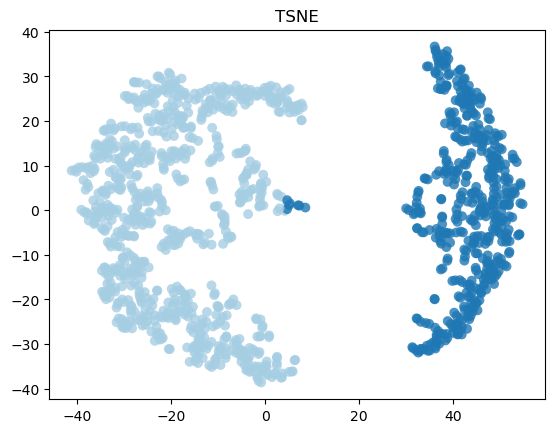

<Figure size 640x480 with 0 Axes>

In [ ]:
tsne=TSNE(random_state=1).fit_transform(X_koh)
plt.figure()
plt.scatter(tsne[:,0],tsne[:,1],lw=0,s=50, alpha=0.8, edgecolors='black', c=np.array(sns.color_palette("Paired"))[predicts_np.astype(int)])
plt.title('TSNE')
plt.show()
plt.clf()

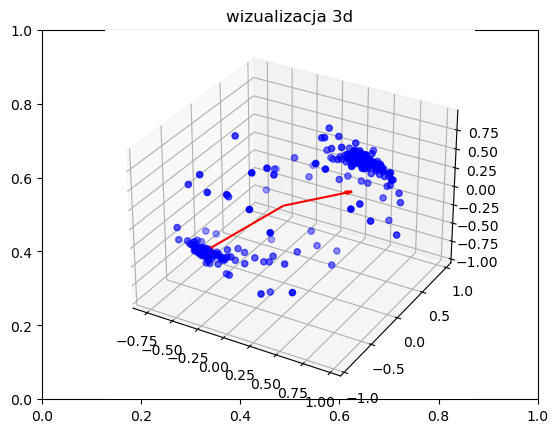

In [ ]:
srodek = [0,0,0]
fig = plt.figure()
plt.title('wizualizacja 3d')
ax=fig.add_subplot(111,projection='3d')

u1,v1,w1 = zip(srodek,srodek)
u2,v2,w2 = zip(koh[0, 0:3], koh[1, 0:3])

ax.quiver(u1,v1,w1,u2,v2,w2,arrow_length_ratio=0.1,colors='red')
ax.scatter(X_koh[:,0],X_koh[:,1],X_koh[:,2],c='blue')

plt.show()

In [12]:
import numpy as np
import pandas as pd
import numpy.random as nrandom
import matplotlib.pyplot as plt
import seaborn as sea
import math, os
from sklearn.metrics import davies_bouldin_score

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

def Kohonen(X, T, alfa, p, wsp_ucz, miara, C1, C2, std):
    #if std True standaryzacja danych (punkt 2.1)
    if std:
        X_std = []
        sum_x = 0

        for i in range(len(X)):
            sum_x = sum_x + X[i]
        
        sr = sum_x/len(X)

        for i in range(len(X)):
            X_std.append((sr - X[i])/np.linalg.norm(sr-X[i]))
        
        X_std = np.array(X_std)
        X = X_std
    
    # inicjalizacja oraz normalizacja wektorów reprezentantów (punkt 2.2)
    vector = []
    rand_gen = np.random.RandomState(0)

    for j in range(p):
        for i in range(len(X)):
            vector_temp = rand_gen.normal(loc=0.0, scale=0.01, size=len(X[0]))
            vector.append(vector_temp/np.linalg.norm(vector_temp))
            
        wek_rep = np.array(vector)
    
    # wybor jednej z 3 miar
    m_table = [0]*len(X)
    alfa_koh = alfa
    for i in range(T):
        if miara == 1:
            modyfikacja = miara1(X, i, p, wek_rep)
            m_table[i%len(X)] = modyfikacja

        if miara == 2:
            modyfikacja = miara2(X, i, p, wek_rep)
            m_table[i%len(X)] = modyfikacja

        if miara == 3:
            modyfikacja = miara3(X, i, p, wek_rep)
            m_table[i%len(X)] = modyfikacja

        # modyfikacja wektorów reprezentantów wg wzorów
        wek_rep[modyfikacja] = wek_rep[modyfikacja] + alfa_koh * (X[i%len(X)] - wek_rep[modyfikacja])
        wek_rep[modyfikacja] = wek_rep[modyfikacja] / np.linalg.norm(wek_rep[modyfikacja])

        # wybor jednego z 3 wspolczynnikow uczenia

        # liniowe zmniejszanie
        if wsp_ucz == 1:
            alfa_koh = alfa*(T-i)/T 
        
        # wykładnicze zmniejszanie
        if wsp_ucz == 2:
            alfa_koh = alfa*math.exp(-C1*i) 
        
        # hiperboliczne zmniejszanie
        if wsp_ucz == 3:
            alfa_koh = C1/(C2+i) 

    return wek_rep, m_table, X

def miara1(X, T_value, p, wek_rep): #miara (3)
    miary = []
    for i in range(p):
        miary.append(np.dot(wek_rep[i], X[T_value % len(X)]))
    
    max_index = np.where(miary == np.amax(miary))
    return max_index[0][0]

def miara2(X, T_value, p, wek_rep): #miara (4)
    miary = []
    for i in range(p):
        miary.append(np.linalg.norm(wek_rep[i] - X[T_value % len(X)]))
    
    max_index = np.where(miary == np.amin(miary))
    return max_index[0][0]

def miara3(X, T_value, p, wek_rep): #miara (5)
    miary = []
    for i in range(p):
        sum_pom = 0
        for j in range(len(wek_rep[0])):
            sum_pom += abs(wek_rep[i][j] - X[T_value % len(X)][j])
        miary.append(math.sqrt(sum_pom))
    
    max_index = np.where(miary == np.amin(miary))
    return max_index[0][0]

# Wyznaczanie liczby klastrów Davies-Bouldin
def best_number_of_class(X, N):
    P = []
    for p in range(2,N):
        wek_rep, tab_m, X_koh = Kohonen(X, 20000, 0.1, p, 1, 1, 1, 1, True)
        result = davies_bouldin_score(X, tab_m)
        P.append(result)
    print(P)

df = pd.read_csv('WineQT.csv', header = None)
df.columns = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality','Id']
X = df['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol',].values
y = pd.factorize(df['quality'])[0]




best_number_of_class(X, 5)
for p in range(2,4):
    for j in range(1,4):
        for i in range(1,4):
            koh, predicts, X_koh = Kohonen(X, 20000, 0.1, p, i, j, 0.3, 0.4, True)
                                # Kohonen(X, T, alfa, p, wsp_ucz, miara, C1, C2, std)
            predicts_np = np.array(predicts)
            title3d= "Wizualizacja3D t-SNE dla p = " + str(p) + ", wsp_ucz = " + str(i) + ", miara = " + str(j)
            
            title = "Kohonen dla p = " + str(p) + ", wsp_ucz = " + str(i) + ", miara = " + str(j)
            srodek = [0,0,0]
            fig = plt.figure()
            ax = fig.add_subplot(projection = '3d')

            u1, v1, w1 = zip(srodek, srodek, srodek)
            u2, v2, w2 = zip(koh[0, 0:3], koh[1, 0:3], koh[2, 0:3])
            ax.quiver(u1, v1, w1, u2, v2, w2)
            ax.scatter(X_koh[0:49,0], X_koh[0:49,1], X_koh[0:49,2], c='r') 
            ax.scatter(X_koh[50:99,0], X_koh[50:99,1], X_koh[50:99,2], c='g') 
            ax.scatter(X_koh[100:149,0], X_koh[100:149,1], X_koh[100:149,2], c='b') 
            plt.title(title3d)
            plt.savefig(title3d + ".png")
            # plt.show()


            tsne_tab= TSNE(random_state=0).fit_transform (X_koh)
            plt.figure(figsize=(10,10))
            plt.scatter(tsne_tab[:,0], tsne_tab[:,1], lw= 0, s=50, alpha=0.8, edgecolors='black', c = np.array(sea.color_palette ("Paired")) [predicts_np.astype(int)])
            plt.title(title)
            plt.savefig(title + ".png")
            # plt.show()
            plt.clf()


NameError: name 'df' is not defined